## Confirm Py6S installation

In [10]:
from Py6S import *
SixS.test()


6S wrapper script by Robin Wilson
Using 6S located at /usr/local/bin/sixsV1.1
Running 6S using a set of test parameters
6sV version: 1.1
The results are:
Expected result: 619.158000
Actual result: 619.158000
#### Results agree, Py6S is working correctly


0

Running for many wavelengths - this may take a long time


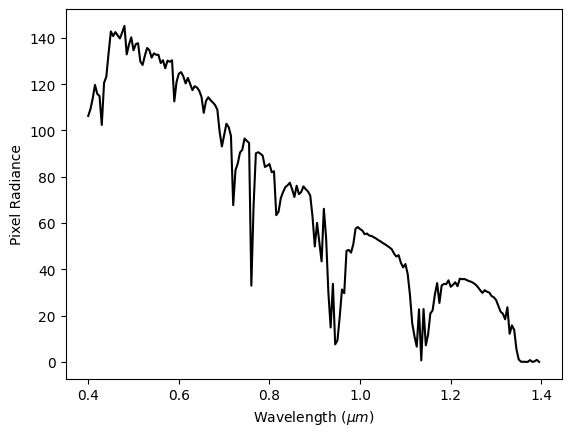

In [3]:
# Create a SixS object called s (used as the standard name by convention)
s = SixS()
# Run the 6S simulation defined by this SixS object across the
# whole VNIR range
wavelengths, results = SixSHelpers.Wavelengths.run_vnir(s, output_name="pixel_radiance")
# Plot these results, with the y axis label set to "Pixel Radiance"
SixSHelpers.Wavelengths.plot_wavelengths(wavelengths, results, "Pixel Radiance")

## Calculate maximum solar energy

In [1]:
import random
import logging
import pytz
import math
import requests
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Py6S import *
from io import StringIO
from datetime import datetime, timedelta
from timezonefinder import TimezoneFinder

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#### Create 1x1 deg grid of all-sky DNI for swath of N. Atlantic for S23

In [ ]:
# Get estimated all-sky DNI from NASA POWER API for swath of N. Atlantic for Summer 2022 (1 deg x 1 deg)
def fetch_data(latitude, longitude): 
    url = f"https://power.larc.nasa.gov/api/temporal/hourly/point?start=20220320&end=20220924&latitude={latitude}&longitude={longitude}&community=sb&parameters=ALLSKY_SFC_SW_DNI&format=csv&header=true&time-standard=utc"
    response = requests.get(url, headers={"accept": "application/json"})
    if response.status_code == 200:
        data = response.content.decode('utf-8')

        # Find the end of the header
        end_of_header = data.find("-END HEADER-") + len("-END HEADER-\n")
        data_no_header = data[end_of_header:]

        try:
            df = pd.read_csv(StringIO(data_no_header))
            return df
        except Exception as e:
            print(f"Error parsing data for latitude {latitude} and longitude {longitude}: {e}")
            return pd.DataFrame()
    else:
        print(f"Failed to fetch data for latitude {latitude} and longitude {longitude}")
        return pd.DataFrame()


In [ ]:
all_data = pd.DataFrame()

for lon in range(-20, -51, -1):  # Step is -1 because we're moving from east to west
    for lat in range(61):
        df = fetch_data(lat, lon)
        if not df.empty:
            df['lat'] = lat  
            df['lon'] = lon 
            all_data = pd.concat([all_data, df], ignore_index=True)
    logging.info(f"Processed all latitudes for longitude {lon}")
    time.sleep(120)

# all_data.to_csv("/Users/timothydonohue/Downloads/nasa_power_data.csv", index=False)

In [60]:
df = pd.read_csv('/Users/timothydonohue/Documents/Data/nasa_power_data.csv')
df.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DNI,lat,lon
0,2022,3,20,0,0.0,0,-20
1,2022,3,20,1,0.0,0,-20
2,2022,3,20,2,0.0,0,-20
3,2022,3,20,3,0.0,0,-20
4,2022,3,20,4,0.0,0,-20


In [48]:
print(df.dtypes)
df.shape

year           int64
month          int64
day            int64
hour           int64
sfc_dni      float64
lat          float64
lon          float64
timestamp      int64
dtype: object


(8577576, 8)

In [61]:
df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}, inplace=True)
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], utc=True)
df['timestamp'] = df['timestamp'].apply(lambda x: int(x.timestamp()))

df = df.drop(['year', 'month', 'day', 'hour'], axis=1)

# convert lat and lon columns to float
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

df.rename(columns={'ALLSKY_SFC_SW_DNI': 'sfc_dni'}, inplace=True)
df

,sfc_dni,lat,lon,timestamp
0,0.00,0.0,-20.0,1647734400
1,0.00,0.0,-20.0,1647738000
2,0.00,0.0,-20.0,1647741600
3,0.00,0.0,-20.0,1647745200
4,0.00,0.0,-20.0,1647748800
...,...,...,...,...
8577571,40.14,60.0,-50.0,1664046000
8577572,34.61,60.0,-50.0,1664049600
8577573,0.00,60.0,-50.0,1664053200
8577574,0.00,60.0,-50.0,1664056800


In [62]:
data_dict = {
    lat: {
        lon: group.set_index('timestamp')['sfc_dni'].apply(
            lambda x: {'sfc_dni': x, 'alt_adj_dni': float('nan')}
        ).to_dict()
        for lon, group in lat_group.groupby('lon')
    }
    for lat, lat_group in df.groupby('lat')
}

output_path = '/Users/timothydonohue/Documents/Data/nasa_power_dict.pkl'
with open(output_path, 'wb') as pickle_file:
    pickle.dump(data_dict, pickle_file)

In [63]:
def print_dict_head(data_dict, num_entries=5):
    count = 0
    for lat, lon_dict in data_dict.items():
        for lon, timestamp_dict in lon_dict.items():
            for timestamp, values in timestamp_dict.items():
                print(f"Lat: {lat}, Lon: {lon}, Timestamp: {timestamp}, Values: {values}")
                count += 1
                if count >= num_entries:
                    return

# Example usage
print_dict_head(data_dict, 6)


Lat: 0.0, Lon: -50.0, Timestamp: 1647734400, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647738000, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647741600, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647745200, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647748800, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647752400, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}


In [5]:
# Access the sfc_dni value
sfc_dni_value = data_dict[0][-50.0][1647752400]['sfc_dni']

# Print the value and its type
print(sfc_dni_value)
type(sfc_dni_value)


0.0
<class 'float'>


#### Built q-table and helper functions

In [3]:
with open('/Users/timothydonohue/Documents/Data/nasa_power_dict.pkl', 'rb') as pickle_file:
    data_dict = pickle.load(pickle_file)

In [4]:
def est_dni_from_py6s(latitude, longitude, altitude, dthz):
    s = SixS()
    dthz_30 = dthz + timedelta(minutes=30)
    logging.debug(f"Will use midpoint of hour (calculated as {dthz_30})")
    
    datetime_str = dthz_30.strftime('%Y-%m-%dT%H:%M:%S')
    s.atmos_profile = AtmosProfile.FromLatitudeAndDate(latitude, datetime_str)
    s.altitudes.set_target_custom_altitude(altitude / 1000)
    
    s.geometry = Geometry.User()
    s.geometry.from_time_and_location(latitude, longitude, datetime_str, 0, 0)
    
    if s.geometry.solar_z > 90:
        logging.debug(f"Sun is below the horizon at {latitude:.2f}, {longitude:.2f}, {altitude}m at {dthz_30}")
        return 0
    
    s.run()
    logging.debug(f"DHI at {latitude:.2f}, {longitude:.2f}, {altitude}m at {dthz_30} is "
                f"{s.outputs.direct_solar_irradiance:.2f} (solar_z: {s.outputs.solar_z})")
    
    dni = s.outputs.direct_solar_irradiance / math.cos(math.radians(s.outputs.solar_z))
    logging.debug(f"Est. DNI at {latitude:.2f}, {longitude:.2f}, {altitude}m at {dthz_30} is {dni:.2f}")
    
    return dni


2024-03-14 19:33:41,949 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 00:30:00+00:00)
2024-03-14 19:33:41,991 - DEBUG - DHI at 31.92, -120.81, 0m at 2022-03-20 00:30:00+00:00 is 107.1 (solar_z: 68)
2024-03-14 19:33:41,992 - DEBUG - Est. DNI at 31.92, -120.81, 0m at 2022-03-20 00:30:00+00:00 is 286.0
2024-03-14 19:33:41,993 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 01:30:00+00:00)
2024-03-14 19:33:42,016 - DEBUG - DHI at 31.92, -120.81, 0m at 2022-03-20 01:30:00+00:00 is 3.3 (solar_z: 81)
2024-03-14 19:33:42,017 - DEBUG - Est. DNI at 31.92, -120.81, 0m at 2022-03-20 01:30:00+00:00 is 21.0
2024-03-14 19:33:42,018 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 02:30:00+00:00)
2024-03-14 19:33:42,019 - DEBUG - Sun is below the horizon at 31.92, -120.81, 0m at 2022-03-20 02:30:00+00:00
2024-03-14 19:33:42,020 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 03:30:00+00:00)
2024-03-14 19:33:42,021 - DEBUG - Sun is below the hori

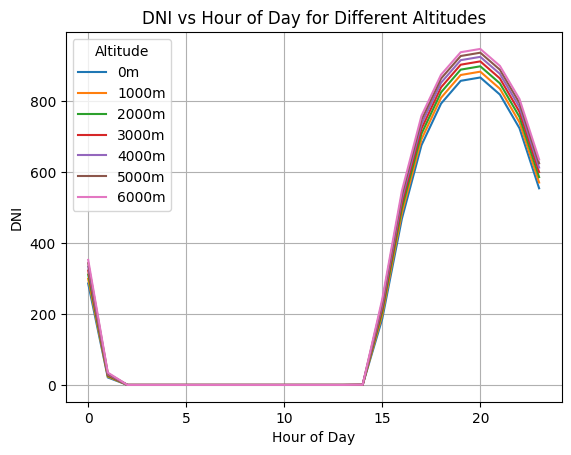

In [78]:
lat = 31.92
lon = -120.81
dtz = datetime(2022, 3, 20, 0, tzinfo=pytz.utc)

# Create a DataFrame to store irradiance data for all hours and altitudes
columns = ['Hour', 'Altitude', 'DNI']
rad_by_hour_and_alt = []

# Loop over altitudes from 0m to 6000m, in steps of 1000m
for alt in range(0, 7000, 1000):
    for hour in range(24):
        dthz = dtz + timedelta(hours=hour)
        irradiance = est_dni_from_py6s(lat, lon, alt, dthz)
        rad_by_hour_and_alt.append({'Hour': hour, 'Altitude': alt, 'DNI': irradiance})

df = pd.DataFrame(rad_by_hour_and_alt)
df.to_csv('/Users/timothydonohue/Downloads/solar_irradiance_ts.csv')

# Plotting
for altitude in range(0, 7000, 1000):
    subset = df[df['Altitude'] == altitude]
    plt.plot(subset['Hour'], subset['DNI'], label=f'{altitude}m')

plt.xlabel('Hour of Day')
plt.ylabel('DNI')
plt.title('DNI vs Hour of Day for Different Altitudes')
plt.legend(title='Altitude')
plt.grid(True)
plt.show()

In [5]:
def adjust_dni_for_altitude(lat, lon, dthz, interpolated_sfc_dni):

    # Get DNI at 0m and 5400m
    dni_at_0m = est_dni_from_py6s(lat, lon, 0, dthz)
    dni_at_5400m = est_dni_from_py6s(lat, lon, 5400, dthz)
    
    # If dni_at_0m is 0, set the adjustment factor to 1, so the original NASA DNI is used
    if dni_at_0m == 0:
        adjustment_factor = 1
    else:
        adjustment_factor = dni_at_5400m / dni_at_0m
        
    logging.debug(f"Altitude factor for {dthz} at {lat:.2f}, {lon:.2f} is {adjustment_factor:.3f}")
    
    # Calculate the adjusted DNI
    adjusted_dni = adjustment_factor * interpolated_sfc_dni
    logging.debug(f"Altitude-adjusted DNI at {lat:.2f}, {lon:.2f} at {dthz} is {adjusted_dni:.2f}")
    
    return adjusted_dni


In [6]:
def bilinear_interpolation(lat, lon, datetime_obj, data_dict):
    """
    Perform bilinear interpolation for a point (lat, lon) at a given datetime using a nested dictionary,
    adjust the DNI value based on altitude, and add both interpolated and adjusted values to the dictionary.
    lat - latitude, lon - longitude, datetime_obj - the specific datetime object for DNI values in UTC.
    data_dict - nested dictionary structure {latitude: {longitude: {unix_timestamp: {'sfc_dni': value}}}}
    """
    unix_timestamp = int(datetime_obj.timestamp())

    if data_dict.get(lat) and data_dict[lat].get(lon) and data_dict[lat][lon].get(unix_timestamp):
        sfc_dni = data_dict[lat][lon][unix_timestamp].get('sfc_dni', float('nan'))
        alt_adj_dni = data_dict[lat][lon][unix_timestamp].get('alt_adj_dni', float('nan'))
        logging.debug(f"DNI values (sfc: {sfc_dni:.2f}, alt-adj: {alt_adj_dni:.2f}) found for "
                      f"{lat:.2f}, {lon:.2f} at {datetime_obj}")
        return sfc_dni, alt_adj_dni

    # Identify the grid cell boundaries
    lat_lower = float(int(lat))
    lat_upper = lat_lower + 1
    lon_left = float(int(lon)) if lon > 0 else float(int(lon) - 1)
    lon_right = lon_left + 1
    logging.debug(f"Interpolation for {lat:.2f}, {lon:.2f} uses cell boundaries: lat [{lat_lower}, {lat_upper}], "
                f"lon [{lon_left}, {lon_right}]")

    values = {}
    for lat_bound in ('lower', 'upper'):
        for lon_bound in ('left', 'right'):
            current_lat = lat_lower if lat_bound == 'lower' else lat_upper
            current_lon = lon_left if lon_bound == 'left' else lon_right
    
            key_name = f"value_{lat_bound}_{lon_bound}"
            values[key_name] = data_dict.get(
                current_lat, {}
            ).get(
                current_lon, {}
            ).get(
                unix_timestamp, {'sfc_dni': float('nan')}
            )['sfc_dni']
            logging.debug(f"Retrieved {values[key_name]:.2f} DNI for {current_lat}, {current_lon} "
                          f"({lat_bound}-{lon_bound}) at {datetime_obj}")

    # Normalized distances
    lat_diff = lat - lat_lower
    lon_diff = lon - lon_left

    # Bilinear interpolation formula
    interpolated_sfc_dni = (values['value_lower_left'] * (1 - lat_diff) * (1 - lon_diff) +
                            values['value_lower_right'] * (1 - lat_diff) * lon_diff +
                            values['value_upper_left'] * lat_diff * (1 - lon_diff) +
                            values['value_upper_right'] * lat_diff * lon_diff)
    logging.debug(f"Interpolated DNI at {lat:.2f}, {lon:.2f} at {datetime_obj} is {interpolated_sfc_dni:.2f}")

    alt_adj_dni = adjust_dni_for_altitude(lat, lon, datetime_obj, interpolated_sfc_dni)

    data_dict.setdefault(lat, {}).setdefault(lon, {})[unix_timestamp] = {'sfc_dni': interpolated_sfc_dni, 'alt_adj_dni': alt_adj_dni}

    return interpolated_sfc_dni, alt_adj_dni


In [7]:
time_step = 3  # Time step in hours
speed = 13  # Speed in m/s

# Constants
earth_circumference_km = 40075
degrees_per_latitude = earth_circumference_km / 360
travel_distance_km = speed * time_step * 3600 / 1000

lat_range = 61  # 0 to 60 degrees inclusive is 61 degrees
degrees_per_step_lat = travel_distance_km / degrees_per_latitude
logging.info(f"Vehicle traveling at {travel_distance_km} km/{time_step} hour(s) can move {degrees_per_step_lat:.2f} degrees latitudinally")
num_lat_steps = int(lat_range / degrees_per_step_lat)
logging.info(f"Domain defined by {lat_range} degrees of latitude discretized into {num_lat_steps} steps")

# Longitude steps for the range -20 to -50 at a representative latitude (e.g., 45 degrees)
# TODO - dynamically handle variation in longitudinal distance (but requires 3-d Q-table for each lat)
lon_range = 31 
representative_lat = 30
degrees_per_longitude_at_lat = np.cos(np.radians(representative_lat)) * degrees_per_latitude
degrees_per_step_lon = travel_distance_km / degrees_per_longitude_at_lat
logging.info(f"Vehicle traveling at {travel_distance_km} km/{time_step} hour(s) can move {degrees_per_step_lon:.2f} degrees longitudinally (representative latitude: {representative_lat})")
num_lon_steps = int(lon_range / degrees_per_step_lon)
logging.info(f"Domain defined by {lon_range} degrees of longitude discretized into {num_lon_steps} steps")

num_time_steps = int(24 / time_step * 365 / 4) 

num_actions = 9


2024-03-14 22:47:41,912 - INFO - Vehicle traveling at 140.4 km/3 hour(s) can move 1.26 degrees latitudinally
2024-03-14 22:47:41,913 - INFO - Domain defined by 61 degrees of latitude discretized into 48 steps
2024-03-14 22:47:41,913 - INFO - Vehicle traveling at 140.4 km/3 hour(s) can move 1.46 degrees longitudinally (representative latitude: 30)
2024-03-14 22:47:41,914 - INFO - Domain defined by 31 degrees of longitude discretized into 21 steps


In [8]:
def take_action(state, action, num_lat_steps, num_lon_steps, num_time_steps):
    lat_index, lon_index, time_index = state
    
    action_effects = {
        0: (1, 0),  # 'N'
        1: (1, 1),  # 'NE'
        2: (0, 1),  # 'E'
        3: (-1, 1), # 'SE'
        4: (-1, 0), # 'S'
        5: (-1, -1),# 'SW'
        6: (0, -1), # 'W'
        7: (1, -1), # 'NW'
        8: (0, 0),  # 'STAY'
    }
    logging.debug(f"Vehicle moves {action_effects[action]} from {lat_index}, {lon_index}")
    
    lat_change, lon_change = action_effects[action]
    
    new_lat_index = max(0, min(num_lat_steps - 1, lat_index + lat_change))
    new_lon_index = max(0, min(num_lon_steps - 1, lon_index + lon_change))
    
    new_time_index = (time_index + 1) % num_time_steps
    logging.debug(f"State at time {new_time_index} becomes {new_lat_index}, {new_lon_index}")

    return new_lat_index, new_lon_index, new_time_index


def convert_state_to_sensible_values(state, num_lat_steps, num_lon_steps, time_step,
                                     lat_range=(0, 60), lon_range=(-50, -20)):
    lat_index, lon_index, time_index = state

    # Adjust geo_lat calculation based on the provided lat_range
    geo_lat = ((lat_index / (num_lat_steps - 1)) * (lat_range[1] - lat_range[0])) + lat_range[0]

    # Adjust geo_lon calculation based on the provided lon_range
    # Using abs() to ensure the correct step calculation for negative ranges
    geo_lon = lon_range[0] + ((lon_index / (num_lon_steps - 1)) * abs(lon_range[0] - lon_range[1]))

    hours = time_index * time_step
    dthz = datetime(2022, 1, 1, tzinfo=pytz.utc) + timedelta(hours=hours)
    
    dthl = dthz
    if logging.getLogger().getEffectiveLevel() == logging.DEBUG:
        tf = TimezoneFinder()
        time_zone_str = tf.timezone_at(lat=geo_lat, lng=geo_lon)
        
        if time_zone_str:
            time_zone = pytz.timezone(time_zone_str)
            dthl = dthz.astimezone(time_zone)
    else:
        # Calculate local time adjustment based on longitude
        local_time_offset = timedelta(hours=geo_lon / 15)
        dthl = dthz + local_time_offset

    return geo_lat, geo_lon, dthz, dthl


In [9]:
def take_action_and_get_reward(state, action, altitude_adjusted=True):
    new_state = take_action(state, action, num_lat_steps, num_lon_steps, num_time_steps)
    geo_lat, geo_lon, dthz, dthl = convert_state_to_sensible_values(new_state, num_lat_steps,
                                                                    num_lon_steps, time_step)
    geo_coords = (geo_lat, geo_lon)
    
    sfc_dni, alt_adj_dni = bilinear_interpolation(geo_lat, geo_lon, dthz, data_dict)  
    reward = alt_adj_dni if altitude_adjusted else sfc_dni
    logging.debug(f"Vehicle moved to {geo_lat:.2f}, {geo_lon:.2f} at {dthz} ({dthl}) with reward {reward:.2f} w/m^2")

    return new_state, reward, geo_coords

#### Calculate starting point

In [4]:
df = df[(df['YEAR'] == 2022) & (df['MO'] == 3) & (df['DY'] == 20)]
df['coords'] = df.apply(lambda row: (row['lat'], row['lon']), axis=1)
df.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DNI,lat,lon,coords
0,2022,3,20,0,0.0,0,-20,"(0.0, -20.0)"
1,2022,3,20,1,0.0,0,-20,"(0.0, -20.0)"
2,2022,3,20,2,0.0,0,-20,"(0.0, -20.0)"
3,2022,3,20,3,0.0,0,-20,"(0.0, -20.0)"
4,2022,3,20,4,0.0,0,-20,"(0.0, -20.0)"


In [12]:
df.groupby('coords')['ALLSKY_SFC_SW_DNI'].mean().reset_index().sort_values('ALLSKY_SFC_SW_DNI', ascending=False)

,coords,ALLSKY_SFC_SW_DNI
874,"(28.0, -44.0)",382.176667
839,"(27.0, -48.0)",375.721667
873,"(28.0, -45.0)",374.184583
843,"(27.0, -44.0)",372.465000
875,"(28.0, -43.0)",372.437083
...,...,...
1687,"(54.0, -37.0)",16.238750
1688,"(54.0, -36.0)",15.941667
1689,"(54.0, -35.0)",15.941667
1720,"(55.0, -35.0)",13.294167


In [10]:
def get_state_from_coordinates(lat, lon, num_lat_steps, num_lon_steps, lat_range_start=0, lon_range_end=-50):
    """
    Convert latitude and longitude to their respective indices in the grid.
    
    :param lat: Latitude to convert.
    :param lon: Longitude to convert.
    :param num_lat_steps: Total number of latitude steps in the grid.
    :param num_lon_steps: Total number of longitude steps in the grid.
    :param lat_range_start: Starting latitude of the grid (0).
    :param lon_range_end: Ending longitude of the grid (-50).
    :return: Indices corresponding to the latitude and longitude.
    """
    # Ensure that lat and lon are within the allowed range
    lat = max(lat_range_start, min(lat_range_start + 60, lat))
    lon = max(lon_range_end, min(-20, lon))

    # Calculate the step size for each latitude and longitude
    lat_step_size = 60 / num_lat_steps
    lon_step_size = abs(lon_range_end + 20) / num_lon_steps  # The range should be positive

    # Calculate the indices
    lat_index = int((lat - lat_range_start) / lat_step_size)
    lon_index = int((lon - lon_range_end) / lon_step_size)  # Adjust based on the end of the range

    return lat_index, lon_index

lat, lon = 28.0, -44.0
lat_index, lon_index = get_state_from_coordinates(lat, lon, num_lat_steps, num_lon_steps, lat_range_start=0, lon_range_end=-50)

print(f"Latitude index: {lat_index}, Longitude index: {lon_index}")


Latitude index: 22, Longitude index: 4


#### Run Q-learning

In [10]:
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPISODES = 1500

actual_altitude = 5400

epsilon = 1.0  # Initial epsilon
epsilon_min = 0.01  # Minimum epsilon value
epsilon_decay = 0.995  # Decay factor

q_table = np.zeros((num_lat_steps, num_lon_steps, num_time_steps, num_actions))
logging.info(f"Q-table created with shape: {q_table.shape}")

initial_time_index = int(1872 / time_step)
initial_lat_index = 22
initial_lon_index = 4
# TODO - allow agent to learn optimal starting lat/lon

eval_metrics = {
    'episode_rewards': [],
    'steps': [],
}

for episode in range(EPISODES):
    total_reward = 0
    episode_details = []

    state = (initial_lat_index, initial_lon_index, initial_time_index)
    init_geo_lat, init_geo_lon, init_dtmz, init_dthl = convert_state_to_sensible_values(state, num_lat_steps, num_lon_steps, time_step)
    
    if episode % 10 == 0 or episode == 0:
        logging.info(f"Episode {episode} - Epsilon: {epsilon}")
    logging.debug(f"Ep. {episode} initialized at {init_dtmz} ({init_dthl}), {init_geo_lat:.2f}, {init_geo_lon:.2f} (index state: {state}); epsilon: {epsilon}")
    
    for step in range(num_time_steps):
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_actions - 1)  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit
        
        new_state, reward, geo_coords = take_action_and_get_reward(state, action)
        total_reward += reward
        
        # Save step details
        step_details = {
            'coords': geo_coords,
            'reward': reward,
        }
        episode_details.append(step_details)

        # Q-table update
        best_future_q = np.max(q_table[new_state])
        q_table[state + (action,)] = q_table[state + (action,)] + LEARNING_RATE * (reward + DISCOUNT_FACTOR * best_future_q - q_table[state + (action,)])
        state = new_state
    
    average_reward = total_reward / num_time_steps 
    eval_metrics['episode_rewards'].append(average_reward)
    eval_metrics['steps'].append(episode_details)

    if episode % 10 == 0:
        logging.info(f"Episode {episode} - average reward: {average_reward:.2f}")
    logging.debug(f"Ep. {episode} ended with average reward: {average_reward:.2f}")
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)


2024-03-14 22:49:09,717 - INFO - Q-table created with shape: (48, 21, 730, 9)
2024-03-14 22:49:09,718 - INFO - Episode 0 - Epsilon: 1.0
2024-03-14 22:49:26,901 - INFO - Episode 0 - average reward: nan


KeyboardInterrupt: 

In [11]:
eval_metrics

{'episode_rewards': [nan],
 'steps': [[{'coords': (28.085106382978722, -44.0), 'reward': 0.0},
   {'coords': (26.80851063829787, -45.5), 'reward': 0.0},
   {'coords': (25.53191489361702, -47.0), 'reward': 515.4515957446807},
   {'coords': (26.80851063829787, -48.5), 'reward': 956.9026766303712},
   {'coords': (25.53191489361702, -50.0), 'reward': nan},
   {'coords': (26.80851063829787, -50.0), 'reward': nan},
   {'coords': (26.80851063829787, -48.5), 'reward': 31.725638297872372},
   {'coords': (25.53191489361702, -48.5), 'reward': 0.0},
   {'coords': (25.53191489361702, -47.0), 'reward': 0.0},
   {'coords': (25.53191489361702, -48.5), 'reward': 0.0},
   {'coords': (25.53191489361702, -48.5), 'reward': 163.0987234042553},
   {'coords': (25.53191489361702, -48.5), 'reward': 699.5629308583696},
   {'coords': (26.80851063829787, -50.0), 'reward': nan},
   {'coords': (25.53191489361702, -48.5), 'reward': 889.9415875612104},
   {'coords': (25.53191489361702, -48.5), 'reward': 71.59127659574

In [13]:
test_eps = 10
test_steps = 12
test_time = 2.926 # seconds
test_sec_per_step = test_time / test_steps

target_eps = 1500
target_steps = num_time_steps
est_run_hours = target_eps * target_steps * test_sec_per_step / 3600
est_run_hours

74.16597222222222